In [20]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
sns.set(color_codes=True)
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas

import datetime
from dateutil.relativedelta import relativedelta

import pandas_ta as ta
import technical_indicators as ti
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pickle

import trade


## Initializations

In [21]:
ticker = 'NVDA'
stock_data_period = '4y'
stock_data_interval = '1d'

outfile = ('./Resources/' + str(ticker) +'_out.csv') # output data for review

num_periods = "1000"
timeframe = "1Day"
short_window = 4
long_window = 20
CCI_period = 20
EVM_period = 14
SMA_EWMA_period_list = [short_window,long_window,100,200]
ROC_period = 5
BBands_period = 50
FI_period = 1


___
## Get live data

In [22]:
# Get live stock data
df = pd.DataFrame()
df = df.ta.ticker(ticker, period = stock_data_period, interval = stock_data_interval)
df.drop(columns=['Dividends', 'Stock Splits'],inplace=True,axis=1)
df

,Open,High,Low,Close,Volume
Date,,,,,
2018-10-01,70.467021,72.426090,70.080167,71.756531,62206000
2018-10-02,71.481264,72.599672,70.819144,71.042336,38396400
2018-10-03,71.746601,71.820993,70.062790,71.104324,32055200
2018-10-04,70.742268,70.985294,68.488098,69.259331,39122000
2018-10-05,69.011337,69.633770,66.345514,66.920830,42663600
...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300
2022-09-27,125.070000,127.360001,122.580002,124.129997,55385400
2022-09-28,124.099998,128.229996,123.540001,127.360001,54241400


___
## Use Technical Indicators to generate additional features for machine learning

In [23]:
# Add technical indicators to dataframe
df = ti.CCI(df, CCI_period) # Feature - CCI (Commodity Channel Index)
df = ti.EVM(df, EVM_period) # Feature - EVM (Ease of Movement)
df = ti.SMA_EWMA(df, SMA_EWMA_period_list) # Features - SMA (Simple Moving Average) & EWMA (Exponentially Weighted Moving Average)
df = ti.ROC(df, ROC_period) # Feature - ROC (price Rate Of Change)
df = ti.BBands(df, BBands_period) # Feature - Bolinger Bands
df = ti.FI(df, FI_period) # Feature - Force Index
df = df.dropna().astype('float')

# df.to_csv(outfile)
df.head()


,Open,High,Low,Close,Volume,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
Date,,,,,,,,,,,,,,,,,,,
2019-07-18,42.323433,42.965263,41.756235,42.335869,44219200.0,98.976854,0.299929,41.932860,41.945081,40.186614,40.314198,41.156748,40.249140,42.342084,40.881491,0.023454,43.540822,33.520780,5.170130e+06
2019-07-19,42.718980,42.783659,41.843305,41.903011,34489600.0,81.993092,0.249433,42.005627,41.928253,40.364983,40.465513,41.185806,40.282489,42.192817,40.893228,0.004952,43.427240,33.581804,-1.492908e+07
2019-07-22,42.116954,42.748831,42.042322,42.619473,31594000.0,87.904081,-0.052502,42.269325,42.204741,40.608281,40.670652,41.226224,40.329595,42.050702,40.913031,0.024212,43.455338,33.566880,2.263587e+07
2019-07-23,43.012528,43.719041,42.855805,43.699139,42817600.0,121.905223,0.347104,42.639373,42.802500,40.894367,40.959080,41.279898,40.397489,41.913676,40.944945,0.051353,43.612894,33.479305,4.622871e+07
2019-07-24,44.131996,44.502666,43.370757,44.445450,36623600.0,139.663566,0.608633,43.166768,43.459680,41.232447,41.291115,41.335594,40.479025,41.789607,40.984982,0.052737,43.978180,33.316922,2.733260e+07


___
## Generate Trading Signals using short and long SMA. Calculate P&L and ROI.

In [24]:
# Create a column to hold the trading signal
df['Signal'] = 0.0

# Generate the trading signal 0 or 1,
# where 1 is the short-window greater than the long-window
# and 0 is when the condition is not met

SMA_short = ('SMA_' + str(short_window))
SMA_long = ('SMA_' + str(long_window))

df['Signal'][short_window:] = np.where(
    df[SMA_short][short_window:] > df[SMA_long][short_window:], 1.0, 0.0
)

# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
df['Entry/Exit'] = df['Signal'].diff()

df.head()

,Open,High,Low,Close,Volume,CCI,EVM,SMA_4,EWMA_4,SMA_20,...,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-18,42.323433,42.965263,41.756235,42.335869,44219200.0,98.976854,0.299929,41.932860,41.945081,40.186614,...,41.156748,40.249140,42.342084,40.881491,0.023454,43.540822,33.520780,5.170130e+06,0.0,NaN
2019-07-19,42.718980,42.783659,41.843305,41.903011,34489600.0,81.993092,0.249433,42.005627,41.928253,40.364983,...,41.185806,40.282489,42.192817,40.893228,0.004952,43.427240,33.581804,-1.492908e+07,0.0,0.0
2019-07-22,42.116954,42.748831,42.042322,42.619473,31594000.0,87.904081,-0.052502,42.269325,42.204741,40.608281,...,41.226224,40.329595,42.050702,40.913031,0.024212,43.455338,33.566880,2.263587e+07,0.0,0.0
2019-07-23,43.012528,43.719041,42.855805,43.699139,42817600.0,121.905223,0.347104,42.639373,42.802500,40.894367,...,41.279898,40.397489,41.913676,40.944945,0.051353,43.612894,33.479305,4.622871e+07,0.0,0.0
2019-07-24,44.131996,44.502666,43.370757,44.445450,36623600.0,139.663566,0.608633,43.166768,43.459680,41.232447,...,41.335594,40.479025,41.789607,40.984982,0.052737,43.978180,33.316922,2.733260e+07,1.0,1.0


In [25]:
df['Entry/Exit'].value_counts()

 0.0    754
 1.0     27
-1.0     27
Name: Entry/Exit, dtype: int64

In [26]:
# Visualize entry position relative to close price
entry = df[df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = df[df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = df[[SMA_short, SMA_long]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = moving_avgs * security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title=(str(ticker) + ': SMA_short, SMA_long, Entry and Exit Points')
)

:Overlay
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

#### Execute trades (buy, hold, sell) and calculate P&L

In [27]:
df, initial_investment, accumulated_shares = trade.gain_loss(df)

In [30]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_investment:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# # Calculate and print the return on investment (ROI)
roi = (total_profit_loss / initial_investment) * 100
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $4,444.54
The total profit/loss of the trading strategy is $5,835.63
The trading algorithm resulted in a return on investment of 131.30%


In [31]:
# # store file for checking trades using Excel
# filepath = Path('./Resources/data.csv')
# df.to_csv(filepath)

---
## Algorithmic Trading - Plot Cummulative Returns

In [49]:
# Filter the date index and close columns
df_bt = df.loc[:, ['Close', 'Signal']]

# Use the pct_change function to generate  returns from close prices
df_bt["Actual Returns"] = df_bt["Close"].pct_change()

# Drop all NaN values from the DataFrame
df_bt = df_bt.dropna()

df_bt['Strategy Returns'] = (df_bt['Actual Returns'] * df_bt['Signal'])

df_bt.head()


,Close,Signal,Actual Returns,Strategy Returns
Date,,,,
2019-07-19,41.903011,0.0,-0.010224,-0.000000
2019-07-22,42.619473,0.0,0.017098,0.000000
2019-07-23,43.699139,0.0,0.025333,0.000000
2019-07-24,44.445450,1.0,0.017078,0.017078
2019-07-25,43.131947,1.0,-0.029553,-0.029553


<AxesSubplot:xlabel='Date'>

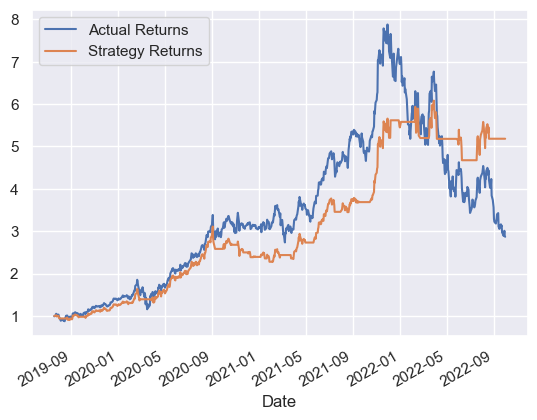

In [50]:
(1 + df_bt[['Actual Returns', 'Strategy Returns']]).cumprod().plot()

---
## Machine Learning

In [51]:
df_ml = df.shift().drop(columns=['Entry/Exit', 'trade_type', 'cost/proceeds']).dropna()
X = df_ml.drop(columns=['Signal'])
y = df_ml['Signal']
X.head()

,Open,High,Low,Close,Volume,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
Date,,,,,,,,,,,,,,,,,,,
2019-07-19,42.323433,42.965263,41.756235,42.335869,44219200.0,98.976854,0.299929,41.932860,41.945081,40.186614,40.314198,41.156748,40.249140,42.342084,40.881491,0.023454,43.540822,33.520780,5.170130e+06
2019-07-22,42.718980,42.783659,41.843305,41.903011,34489600.0,81.993092,0.249433,42.005627,41.928253,40.364983,40.465513,41.185806,40.282489,42.192817,40.893228,0.004952,43.427240,33.581804,-1.492908e+07
2019-07-23,42.116954,42.748831,42.042322,42.619473,31594000.0,87.904081,-0.052502,42.269325,42.204741,40.608281,40.670652,41.226224,40.329595,42.050702,40.913031,0.024212,43.455338,33.566880,2.263587e+07
2019-07-24,43.012528,43.719041,42.855805,43.699139,42817600.0,121.905223,0.347104,42.639373,42.802500,40.894367,40.959080,41.279898,40.397489,41.913676,40.944945,0.051353,43.612894,33.479305,4.622871e+07
2019-07-25,44.131996,44.502666,43.370757,44.445450,36623600.0,139.663566,0.608633,43.166768,43.459680,41.232447,41.291115,41.335594,40.479025,41.789607,40.984982,0.052737,43.978180,33.316922,2.733260e+07


In [52]:
# Review y value counts
y.value_counts()

1.0    484
0.0    324
Name: Signal, dtype: int64

In [53]:
# Split train - test data
split_ratio=0.8
train_size = int(round(split_ratio * X.shape[0]))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(646, 19) (646,)
(162, 19) (162,)


In [38]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


### Use the 'XGBoost' classifier model to fit the training data and make predictions based on the testing data.

In [39]:
# Instantiate XGB classifier model instance
model = xgb.XGBClassifier()
 
# Fit the model to the data using the training data
model = model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0])

In [40]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report = classification_report(y_test, pred)

# Print the classification report
print(testing_report)

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       105
         1.0       0.98      0.88      0.93        57

    accuracy                           0.95       162
   macro avg       0.96      0.93      0.94       162
weighted avg       0.95      0.95      0.95       162



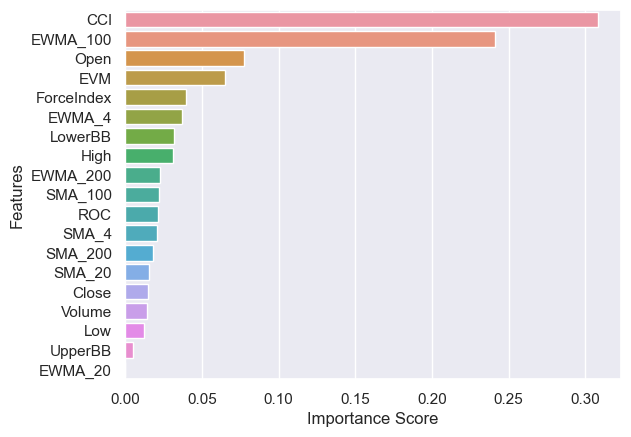

In [41]:
# Show ranking of importance score of features for this dataset
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()

In [42]:
pickle.dump(model, open('./Resources/NVDA_ml_model.pkl', 'wb'))

---
## Machine Learning - Plot Cummulative Returns

In [45]:
# Filter the date index and close columns
data_bt = df.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
data_bt["Actual Returns"] = data_bt["Close"].pct_change()

# Drop all NaN values from the DataFrame
data_bt = data_bt.dropna()

# Review the DataFrame
data_bt.head()


,Close,Actual Returns
Date,,
2019-07-19,41.903011,-0.010224
2019-07-22,42.619473,0.017098
2019-07-23,43.699139,0.025333
2019-07-24,44.445450,0.017078
2019-07-25,43.131947,-0.029553


,Close,Actual Returns
Date,,
2022-09-26,122.279999,-0.023011
2022-09-27,124.129997,0.015129
2022-09-28,127.360001,0.026021
2022-09-29,122.199997,-0.040515
2022-09-30,121.389999,-0.006628


In [46]:
X_scaled = X_scaler.transform(X)
pred_bt = model.predict(X_scaled)

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = pred_bt

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = data_bt['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (predictions_df['Actual Returns'] * predictions_df['Predicted'])

# Review the DataFrame
predictions_df


,Predicted,Actual Returns,Strategy Returns
Date,,,
2019-07-19,0,-0.010224,-0.000000
2019-07-22,0,0.017098,0.000000
2019-07-23,0,0.025333,0.000000
2019-07-24,0,0.017078,0.000000
2019-07-25,1,-0.029553,-0.029553
...,...,...,...
2022-09-26,0,-0.023011,-0.000000
2022-09-27,0,0.015129,0.000000
2022-09-28,0,0.026021,0.000000


In [47]:
# # store file for checking trades using Excel
# filepath = Path('./Resources/data_pred.csv')
# predictions_df.to_csv(filepath)

<AxesSubplot:xlabel='Date'>

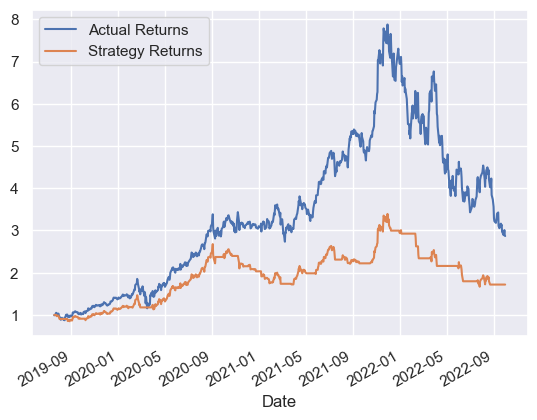

In [48]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()